### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [1]:
from os.path import isdir
from os import mkdir

env = 'pc'  # 'pc', 'colab'
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/accuracy_track/'
experiment = 'Exp5/'

save_dir = ''
if env == 'pc':
    save_dir = f'C:/Users/79137/Pasha/2. UNIPD/Semester 2/Optimization for Data Science/Homeworks/HW 1/Semi-Supervised-Labelling/'
elif env == 'colab':
    save_dir = f'/content/drive/MyDrive/UNIPD/ODS/HW1/'

In [2]:
%%capture

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

# Saving directory

In [3]:
full_dir = f'{save_dir}{experiment}'
assert(isdir(save_dir))

if not isdir(full_dir):
    mkdir(full_dir)

assert(isdir(full_dir))

In [4]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

In [5]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [6]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

In [7]:
# %%timeit
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state,
    cluster_std = 1.5
)


def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

In [8]:
# %%timeit

# Old inefficient weights calculation
# weights = calc_weight_matrix(X, weight_func = None)

from sklearn.metrics import pairwise_distances

weights = pairwise_distances(X, metric = 'euclidean')
weights = 1 / (weights + 0.001)
assert(weights.shape == (DataProperties.n_samples, DataProperties.n_samples))

Data shape: X: (500, 2), Y: (500,)


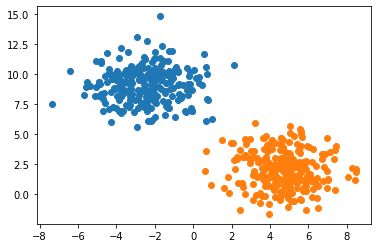

In [9]:
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 250 instances of object 0.0
We have to delabel 237 instances
Found 250 instances of object 1.0
We have to delabel 237 instances

    We have 474 unlabeled data
    Out of 500
    


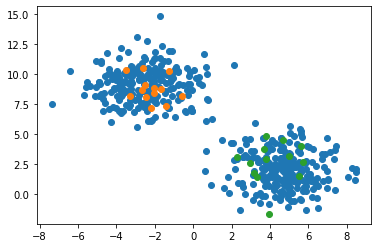

In [10]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [11]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled
print(class_stats)

Counter({-1000000.0: 474, 0.0: 13, 1.0: 13})


# Gradient descent

In [12]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.001
)

In [17]:
Y_preds_GD = solver.solve(
    X, 
    Y_delabeled,
    Y_true = Y,
    iter_limit = 30,
    delta_percent_limit = 0.1,  # when dLoss / dLoss prev < 0.02
    delta_loss_limit = 0.0, # dont use
    stop_loss = 0.0,  # dont use
    weight_matrix = weights
)

Iteration: 0, Loss: 1107.5101523963954, delta loss: 1107.5101523963954
Iteration: 1, Loss: 1083.6450982037973, delta loss: -23.86505419259811
Iteration: 2, Loss: 1066.5319367228426, delta loss: -17.11316148095466
Iteration: 3, Loss: 1053.8670792755365, delta loss: -12.664857447306076
Iteration: 4, Loss: 1044.2989125491665, delta loss: -9.56816672637001
Iteration: 5, Loss: 1036.9701031187417, delta loss: -7.328809430424826
Iteration: 6, Loss: 1031.303062618225, delta loss: -5.667040500516578
Iteration: 7, Loss: 1026.8910774087792, delta loss: -4.411985209445902
Iteration: 8, Loss: 1023.4385723439926, delta loss: -3.4525050647865783
Iteration: 9, Loss: 1020.7258896919361, delta loss: -2.7126826520565146
Iteration: 10, Loss: 1018.5871841297237, delta loss: -2.138705562212408
Iteration: 11, Loss: 1016.8958134877538, delta loss: -1.691370641969911
Iteration: 12, Loss: 1015.5542765327453, delta loss: -1.3415369550084506
Iteration: 13, Loss: 1014.487056042838, delta loss: -1.0672204899072995


Accuracy: 1.0


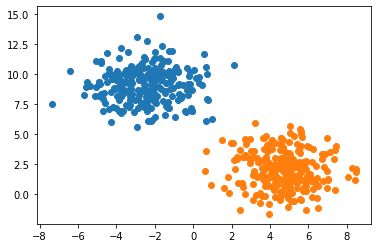

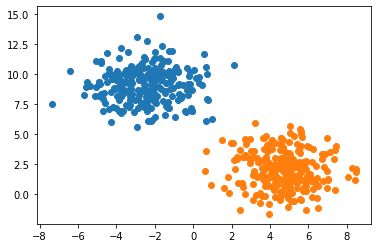

In [18]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

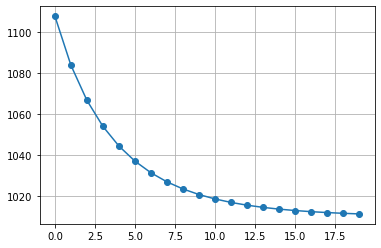

In [19]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

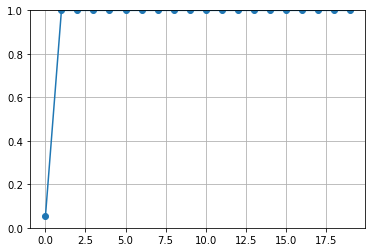

In [20]:
plt.plot(solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [22]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [23]:
Y_preds_BCGD_permutation = random_solver.solve(
    X, 
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 30,
    delta_percent_limit = 0.1,  # when dLoss / dLoss prev
    delta_loss_limit = 0.0,
    stop_loss= 0.0,
    weight_matrix = weights
)

Iteration: 0, Loss: 1107.5101523963954, Delta: 1107.5101523963954
Iteration: 1, Loss: 1080.8476870158072, Delta: 26.662465380588174
Iteration: 2, Loss: 1062.4162601812634, Delta: 18.4314268345438
Iteration: 3, Loss: 1049.265821457975, Delta: 13.150438723288289
Iteration: 4, Loss: 1039.6848878462438, Delta: 9.580933611731325
Iteration: 5, Loss: 1032.597933893011, Delta: 7.086953953232751
Iteration: 6, Loss: 1027.3003796955961, Delta: 5.297554197414911
Iteration: 7, Loss: 1023.3102033538112, Delta: 3.990176341784945
Iteration: 8, Loss: 1020.2884709777222, Delta: 3.0217323760889485
Iteration: 9, Loss: 1017.9860206666806, Delta: 2.302450311041639
Iteration: 10, Loss: 1016.2239580579701, Delta: 1.7620626087104938
Iteration: 11, Loss: 1014.8689812742987, Delta: 1.3549767836714182
Iteration: 12, Loss: 1013.8226196687987, Delta: 1.0463616055000102
Iteration: 13, Loss: 1013.0108919771006, Delta: 0.8117276916980245
Iteration: 14, Loss: 1012.3778651193834, Delta: 0.6330268577172546
Iteration: 15,

Accuracy: 1.0


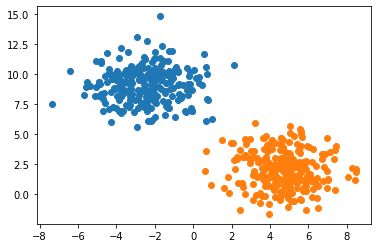

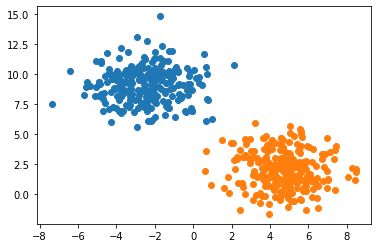

In [24]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

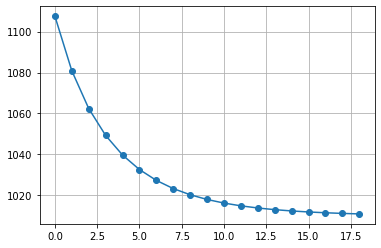

In [25]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

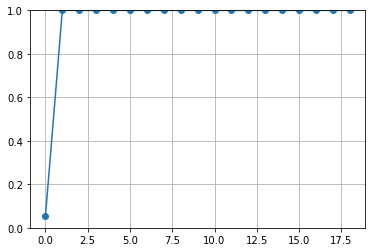

In [26]:
plt.plot(random_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

## BCGD random sampling

In [27]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,
    bcgd_strategy = 'random sampling'
)

In [30]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled,
    Y_true = Y,
    iter_limit = 30, #  * len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]),
    delta_loss_limit = 0.0,
    delta_percent_limit = 0.0,  # when dLoss / dLoss prev
    stop_loss= 0,
    weight_matrix = weights
)

Iteration: 0, Loss: 1107.5101523963954, Delta: 1107.5101523963954
Iteration: 1, Loss: 1107.43237068124, Delta: 0.07778171515542454
Iteration: 2, Loss: 1107.4255895210076, Delta: 0.006781160232321781
Iteration: 3, Loss: 1107.3624786034436, Delta: 0.06311091756401765
Iteration: 4, Loss: 1107.2999737600683, Delta: 0.06250484337533635
Iteration: 5, Loss: 1107.2910831044874, Delta: 0.008890655580898965
Iteration: 6, Loss: 1107.2194433551024, Delta: 0.07163974938498541
Iteration: 7, Loss: 1107.20970681881, Delta: 0.009736536292393794
Iteration: 8, Loss: 1107.1817337480527, Delta: 0.027973070757298046
Iteration: 9, Loss: 1107.0938564777266, Delta: 0.08787727032608927
Iteration: 10, Loss: 1107.084269586115, Delta: 0.009586891611661486
Iteration: 11, Loss: 1107.0811942650332, Delta: 0.003075321081723814
Iteration: 12, Loss: 1107.0761434893918, Delta: 0.005050775641393557
Iteration: 13, Loss: 1107.0129139678509, Delta: 0.06322952154096129
Iteration: 14, Loss: 1107.008860824206, Delta: 0.00405314

Accuracy: 0.552


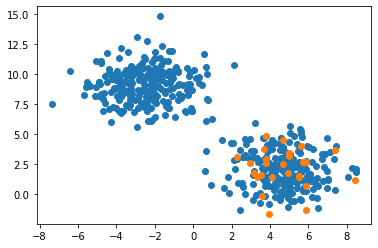

In [31]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

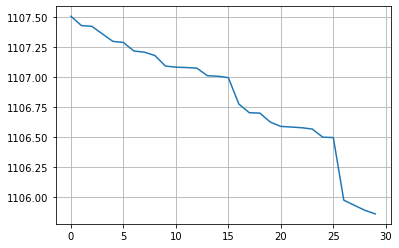

In [32]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

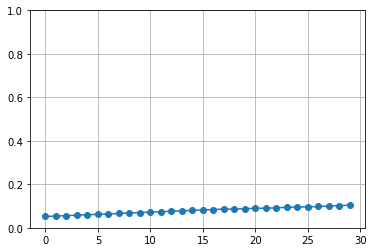

In [33]:
plt.plot(BCGD_RS_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

## BCGD cyclic

In [34]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,
    bcgd_strategy = 'cyclic'
)

In [36]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 30, 
    delta_percent_limit = 0.10,  # when dLoss / dLoss prev
    delta_loss_limit = 0.0,
    stop_loss = 0,
    weight_matrix = weights
)

Iteration: 0, Loss: 1107.5101523963954, Delta: 1107.5101523963954
Iteration: 1, Loss: 1080.8441163316559, Delta: 26.6660360647395
Iteration: 2, Loss: 1062.3872348806692, Delta: 18.456881450986657
Iteration: 3, Loss: 1049.2067649379549, Delta: 13.180469942714353
Iteration: 4, Loss: 1039.5975724311488, Delta: 9.609192506806039
Iteration: 5, Loss: 1032.4933553150256, Delta: 7.104217116123209
Iteration: 6, Loss: 1027.188946249916, Delta: 5.304409065109667
Iteration: 7, Loss: 1023.1990425048089, Delta: 3.9899037451070853
Iteration: 8, Loss: 1020.1802516477686, Delta: 3.018790857040244
Iteration: 9, Loss: 1017.8848266002966, Delta: 2.2954250474720084
Iteration: 10, Loss: 1016.1315382097453, Delta: 1.7532883905513472
Iteration: 11, Loss: 1014.7864807765555, Delta: 1.3450574331897087
Iteration: 12, Loss: 1013.7499789643618, Delta: 1.0365018121937055
Iteration: 13, Loss: 1012.9474220953234, Delta: 0.8025568690384262
Iteration: 14, Loss: 1012.3227214833254, Delta: 0.624700611998037
Iteration: 15

Accuracy: 1.0


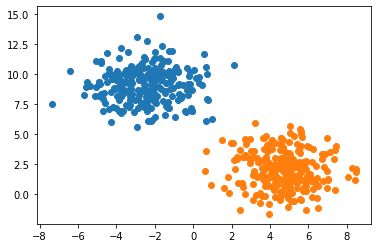

In [37]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

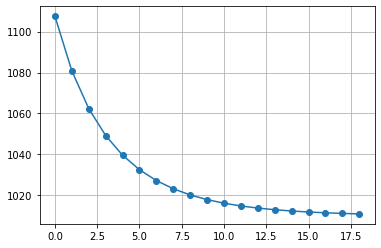

In [38]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

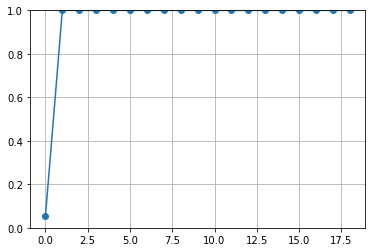

In [39]:
plt.plot(BCGD_cyclic_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [46]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    # 'BCGD sampling': bcgd_sampling_solver,
}

In [47]:
def compare_models(solvers_dict, X, Y_true, Y_delabeled, iters_limit, delta_percent_limit, delta_loss_limit, stop_loss, weights_matrix):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times_total = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        print(f'Fitting {model_name}')
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            Y_true = Y_true,
            iter_limit = iters_limit,
            delta_percent_limit = delta_percent_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss,
            weight_matrix = weights_matrix
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times_total[model_name] = end - start
    

    return predictions, losses, n_iterations, cpu_times_total

In [48]:
iters_limit = 20
delta_loss_limit = 0.0  # we dont use it anymore
stop_loss= 0  # we dont use it anymore
delta_percent_limit = 0.1,  # when dLoss / dLoss prev


preds, losses, n_iters, cpu_times_total = compare_models(
        solvers,
        X,
        Y_delabeled = Y_delabeled,
        Y_true = Y,
        iters_limit = iters_limit,
        delta_percent_limit = delta_percent_limit,
        delta_loss_limit = delta_loss_limit,
        stop_loss = stop_loss,
        weights_matrix =  weights
    )

Fitting GD
Iteration: 0, Loss: 1107.5101523963954, delta loss: 1107.5101523963954
Iteration: 1, Loss: 1083.6450982037973, delta loss: -23.86505419259811
Iteration: 2, Loss: 1066.5319367228426, delta loss: -17.11316148095466
Iteration: 3, Loss: 1053.8670792755365, delta loss: -12.664857447306076
Iteration: 4, Loss: 1044.2989125491665, delta loss: -9.56816672637001
Iteration: 5, Loss: 1036.9701031187417, delta loss: -7.328809430424826
Iteration: 6, Loss: 1031.303062618225, delta loss: -5.667040500516578
Iteration: 7, Loss: 1026.8910774087792, delta loss: -4.411985209445902
Iteration: 8, Loss: 1023.4385723439926, delta loss: -3.4525050647865783
Iteration: 9, Loss: 1020.7258896919361, delta loss: -2.7126826520565146
Iteration: 10, Loss: 1018.5871841297237, delta loss: -2.138705562212408
Iteration: 11, Loss: 1016.8958134877538, delta loss: -1.691370641969911
Iteration: 12, Loss: 1015.5542765327453, delta loss: -1.3415369550084506
Iteration: 13, Loss: 1014.487056042838, delta loss: -1.067220

In [49]:
accuracies = {name: solver.accuracies for name, solver in solvers.items()}
cpu_times = {name: solver.cpu_times for name, solver in solvers.items()}

## Saving data

In [50]:
# iters_limit = 17
# delta_loss_limit = 0.0001
# stop_loss= 21000  # 4000

experiment_params = pd.DataFrame(
    {
        'iters_limit': [iters_limit],
        'd_loss_limit': [delta_loss_limit],
        'stop_loss': [stop_loss],
        'learning_rate': [lr],
        'n points': [DataProperties.n_samples]
    },
    # index = False
)

experiment_params.to_csv(full_dir + 'experiment_params.csv')
experiment_params.head()

,iters_limit,d_loss_limit,stop_loss,learning_rate,n points
0,20,0.0,0,0.001,500


In [51]:
results = pd.DataFrame()

# fill losses
for model_name, loss in losses.items():
    new = pd.DataFrame({f'{model_name} loss': loss})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} loss'] = loss

for model_name, cpu_time in cpu_times.items():
    new = pd.DataFrame({f'{model_name} cpu': cpu_time})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} cpu'] = cpu_time

for model_name, acc in accuracies.items():
    new = pd.DataFrame({f'{model_name} acc': acc})
    results = pd.concat([results, new], axis = 1)


results.to_csv(full_dir + 'res.csv')
results.head()

,GD loss,BCGD permutation loss,BCGD cyclic loss,GD cpu,BCGD permutation cpu,BCGD cyclic cpu,GD acc,BCGD permutation acc,BCGD cyclic acc
0,1107.510152,1107.510152,1107.510152,0.261332,0.230540,0.240228,0.052,0.052,0.052
1,1083.645098,1080.846428,1080.844116,0.835035,0.751159,0.757606,1.000,1.000,1.000
2,1066.531937,1062.414583,1062.387235,1.420240,1.293130,1.269916,1.000,1.000,1.000
3,1053.867079,1049.263410,1049.206765,1.945552,1.854749,1.796797,1.000,1.000,1.000
4,1044.298913,1039.677853,1039.597572,2.470946,2.376866,2.320974,1.000,1.000,1.000


,CPU total time,N iterations,Final accuracy,CPU total time_norm,N iterations_norm,Final accuracy_norm
GD,10.573890,19,1.0,1.000000,1.000000,1.0
BCGD permutation,9.762518,18,1.0,0.923266,0.947368,1.0
BCGD cyclic,9.709042,18,1.0,0.918209,0.947368,1.0


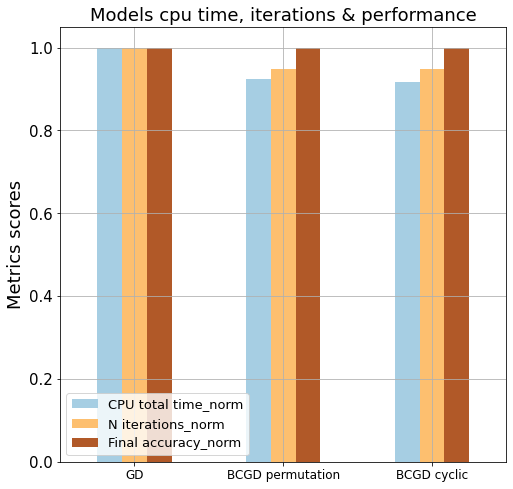

In [52]:
bar_metrics = pd.DataFrame.from_dict(cpu_times_total, orient='index', columns = ['CPU total time'])
bar_metrics['N iterations'] = n_iters.values()

final_accuracies = {name: acc[-1] for name, acc in accuracies.items()}
bar_metrics['Final accuracy'] = final_accuracies.values()



normalize_cols(bar_metrics)
cols_to_plot = [c for c in bar_metrics.columns if 'norm' in c]

plot_bar_metrics(bar_metrics.loc[:, cols_to_plot])
bar_metrics.to_csv(full_dir + 'metrics res.csv')

bar_metrics.head()

## Graphics

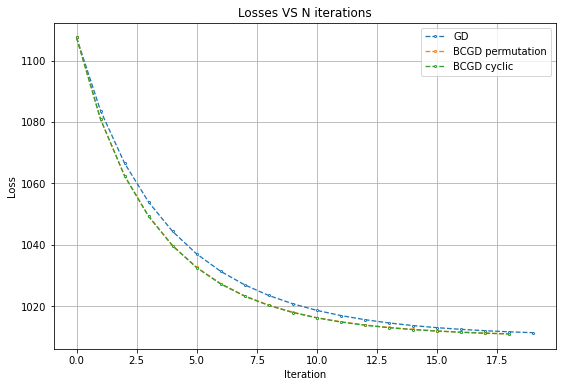

In [53]:
def plot_curves(curves_dict, title, y_label, figsize):
    _, ax = plt.subplots(figsize = figsize)

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


# plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
# plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(
    losses,
    'Losses VS N iterations', 
    y_label = 'Loss',
    figsize = (9, 6)
)

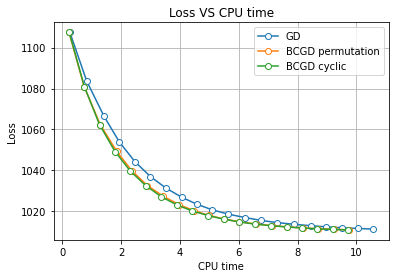

In [54]:
def plot_losses_vs_cpu(losses_, cpu_times_):
    assert(list(losses_.keys()) == list(cpu_times_.keys()))

    _, ax = plt.subplots()

    for model_name, loss in losses_.items():
        cpu_time = cpu_times_[model_name]

        ax.plot(
            cpu_time,
            loss,
            marker = 'o',
            markerfacecolor = 'white'
        )
    plt.xlabel('CPU time')
    plt.ylabel('Loss')
    plt.title('Loss VS CPU time')
    plt.legend(list(losses_.keys()))
    plt.grid()


plot_losses_vs_cpu(losses, cpu_times)

# Real dataset

In [ ]:
# df = pd.read_csv('Pokemon.csv')

In [ ]:
# df.head()

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [ ]:
# df.head()
# X_real = df.loc[:, ['total', 'sp_attack']].values
# Y_real = df['legendary'].astype('int').values


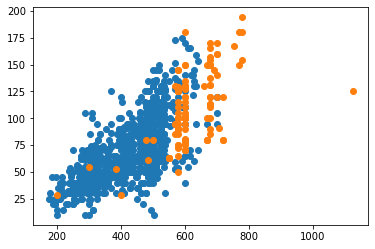

In [ ]:
# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# Y_real_delabeled = delabel_data(
#     Y_real,
#     labeled_percent = 0.16, # DataProperties.labeled_percentage,
#     delabel_value = DataProperties.unlabeled
# )

Found 954 instances of object 0
We have to delabel 801 instances
Found 118 instances of object 1
We have to delabel 99 instances


In [ ]:
# wine=datasets.load_wine()

# #Conver to pandas dataframe
# data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

# data = data.loc[
#     (data['target'] == 1) | (data['target'] == 0),
#     ['od280/od315_of_diluted_wines', 'alcohol', 'target']
# ]

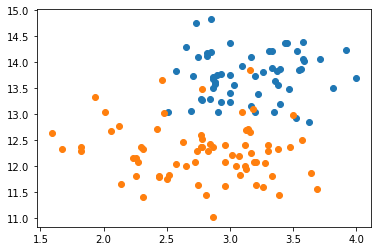

In [ ]:
# X_real = data.loc[
#     :,
#     ['od280/od315_of_diluted_wines', 'alcohol']
# ].values
# Y_real = data['target'].values

# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# solver = GradientDescentSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = None
# )

# Y_real_preds = solver.solve(
#     X_real,
#     Y_real_delabeled,
#     iter_limit=5,
#     delta_loss_limit = 0.003,
#     stop_loss = 20
# )

Iteration: 0, Loss: 24173.807351957803, delta loss: 24173.807351957803
Iteration: 1, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 2, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 3, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 4, Loss: 24173.807351957803, delta loss: 0.0


